<a href="https://colab.research.google.com/github/shaytanne/runi-reinforcement_learning-assignment2/blob/branch_Yossi/MidProject_tabular_RL_Minigrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - Reinforcements Learning 2025
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install gymnasium
!pip install minigrid
!pip install pygame

# Imports

In [2]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [3]:
import sys
import os

print("Starting virtual display...")
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900))
display.start()
print("Display started")

print(f"Running in temporary Colab folder: {os.getcwd()}")

Starting virtual display...
Display started
Running in temporary Colab folder: /content


In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [5]:
# =============================================================================
# CONSTANTS & MAPPINGS
# =============================================================================
# These dictionaries map object names to integer IDs for the observation tensor.
# This ensures the neural network receives consistent numerical representations.
OBJECT_TO_IDX = {
    "unseen": 0, "empty": 1, "wall": 2, "floor": 3, "door": 4,
    "key": 5, "ball": 6, "box": 7, "goal": 8, "lava": 9, "agent": 10,
}
IDX_TO_OBJECT = {i: name for name, i in OBJECT_TO_IDX.items()}
COLOR_TO_IDX = {name: i for i, name in enumerate(COLOR_NAMES)}
IDX_TO_COLOR = {i: name for i, name in enumerate(COLOR_NAMES)}

# =============================================================================
# BASE ENVIRONMENT WRAPPER
# =============================================================================
class MiniGridEnv(BaseMiniGridEnv):
    """
    A compatibility wrapper around the modern gymnasium-minigrid BaseMiniGridEnv.
    It handles default MissionSpace initialization which is required in newer versions
    but often unused in simple RL tasks.
    """
    def __init__(
        self,
        grid_size=None,
        width=None,
        height=None,
        max_steps=10000,
        see_through_walls=False,
        agent_view_size=7,
        render_mode=None,
        mission_space=None,
        **kwargs
    ):
        # Newer Minigrid versions strictly require a MissionSpace.
        # We provide a dummy default if one isn't passed.
        if mission_space is None:
            mission_space = MissionSpace(mission_func=lambda: "do something")

        super().__init__(
            grid_size=grid_size,
            width=width,
            height=height,
            max_steps=max_steps,
            see_through_walls=see_through_walls,
            agent_view_size=agent_view_size,
            render_mode=render_mode,
            mission_space=mission_space,
            **kwargs
        )

    def reset(self, *, seed=None, options=None):
        return super().reset(seed=seed, options=options)

In [6]:
# =============================================================================
# ENVIRONMENT 1: RANDOM EMPTY GRID
# =============================================================================
class RandomEmptyEnv_10(MiniGridEnv):
    """
    A 10x10 grid environment with no obstacles inside, just outer walls.
    The agent and goal start positions are randomized within specific constraints.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        **kwargs,
    ):
        self.init_agent_pos = agent_start_pos
        self.init_agent_dir = agent_start_dir

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)

        # Heuristic for max steps: typically enough to explore the grid fully
        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True, # Agent has full observability of the room
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)
        self.walls_init = []
        # Default goal position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])

        # 2. Call parent reset, which internally calls _gen_grid()
        return super().reset(seed=seed, options=options)

    def _gen_grid(self, width, height):
        """
        Procedurally generates the grid layout: walls, goal, and agent.
        """
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def step(self, action):
        """
        Standard step function with Sparse Reward modification.
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # Sparse Reward: Only reward 1.0 upon reaching the goal (termination)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0

        return obs, reward, terminated, truncated, info

    # Getters for wrapper compatibility
    def get_k_pos(self): return getattr(self, 'key_pos', None)
    def get_d_pos(self): return getattr(self, 'door_pos', None)
    def get_goal_pos(self): return self.goal_pos


In [7]:
# =============================================================================
# ENVIRONMENT 2: RANDOM KEY & DOOR
# =============================================================================
class RandomKeyMEnv_10(MiniGridEnv):
    """
    A 10x10 grid separated into two rooms by a vertical wall (partition).
    The agent must find a key, open a locked door in the partition, and reach the goal.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        partition_col=3, # Column index where the dividing wall is placed
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.partition_col = partition_col
        self.walls_init = []

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        """
        Generates: Outer walls -> Partition Wall -> Door -> Key -> Goal.
        """
        # 1. Create empty grid and outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # 2. Define Partition Wall and Door Location
        # Choose a random row for the door (pass_loc)
        self.pass_loc = random.choice([op_row for op_row in range(1, height-1)])
        # Create a vertical wall at partition_col
        self.walls_init = [(self.partition_col, i) for i in range(0, height)]

        # Place the partition wall objects
        for column, row in self.walls_init:
            if 0 <= column < width and 0 <= row < height:
                self.grid.set(column, row, Wall())

        # 3. Place Key and Door
        # Key is placed randomly in the left room (columns 1 to partition_col)
        self.key_pos = (
            random.choice([k_col for k_col in range(1, self.partition_col)]),
            random.choice([k_row for k_row in range(2, height-1)])
        )
        self.door_pos = (self.partition_col, self.pass_loc)

        # Place the Locked Door (replaces the wall at pass_loc)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Place the Key
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # 4. Place Goal (Randomly in the right upper or lower corner)
        self.goal_pos = random.choice([(8,1), (8,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 5. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

    def step(self, action):
        # Standard step with sparse reward logic
        obs, reward, terminated, truncated, info = super().step(action)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        return obs, reward, terminated, truncated, info

    # Getters
    def get_k_pos(self): return self.key_pos
    def get_d_pos(self): return self.door_pos
    def get_goal_pos(self): return self.goal_pos


# Wrappers

In [8]:
# =============================================================================
# OBSERVATION WRAPPER
# =============================================================================
class KeyFlatObsWrapper(gym.ObservationWrapper):
    """
    Transforms the observation from a 2D image/grid to a 1D flat vector.
    """
    def __init__(self, env):
        super().__init__(env)

        # Define observation space:
        # We strip the outer walls (width-2, height-2).
        # Each cell has 3 attributes (Object ID, Color ID, State/Direction).
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),
            dtype='uint8'
        )
        self.get_init_map()

    def observation(self, obs):
        """
        Process the grid state into a flat vector.
        """
        env = self.unwrapped

        # 1. Get the full numerical encoding of the grid
        full_grid = env.grid.encode()

        # 2. Inject Agent State
        # Minigrid's 'encode()' often treats the agent separately.
        # Here, we overwrite the grid cell at agent_pos with agent details.
        if env.agent_pos is not None:
            full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
                OBJECT_TO_IDX['agent'],
                COLOR_TO_IDX['red'],
                env.agent_dir
            ])

        # 3. Crop Outer Walls
        # Slicing [1:-1, 1:-1] removes the standard boundary walls to reduce dim.
        full_grid = full_grid[1:-1, 1:-1]

        # 4. Flatten to 1D array
        return full_grid.ravel()

    # --- Helper methods for Analysis / Debugging ---

    def is_carrying_key(self):
        """Check if the agent is currently holding the key object."""
        return self.unwrapped.carrying is not None and self.unwrapped.carrying.type == 'key'

    def is_door_open(self):
        """Check the state of the specific environment door."""
        if hasattr(self.unwrapped, 'env_door') and self.unwrapped.env_door:
            return self.unwrapped.env_door.is_open
        return False

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_goal_pos(self):
        return self.unwrapped.goal_pos
    
    def get_door_pos(self):
        return self.unwrapped.get_d_pos()

    def get_key_pos(self):
        return self.unwrapped.get_k_pos()

    def get_init_map(self):
        """
        Creates a binary map (walls vs empty) of the environment structure.
        Used for visualization or pathfinding heuristics.
        """
        env = self.unwrapped
        # Note: Minigrid uses (x, y), numpy uses (row, col) -> (y, x).
        map_u = np.zeros((env.height, env.width), dtype=int)

        # Mark outer walls
        map_u[0, :] = 1
        map_u[-1, :] = 1
        map_u[:, 0] = 1
        map_u[:, -1] = 1

        # Mark inner walls
        if hasattr(env, 'walls_init'):
            for x, y in env.walls_init:
                if 0 <= y < env.height and 0 <= x < env.width:
                    map_u[y, x] = 1

        self.init_map = map_u.tolist()

    def get_updated_map(self):
        """
        Returns a character-based map (ASCII) showing the current state
        of entities (Agent 'P', Goal 'G', Door 'D', Key 'K').
        """
        current_map = copy.deepcopy(self.init_map)

        # 1. Place Agent ('P' for Player)
        ax, ay = self.unwrapped.agent_pos
        current_map[ay][ax] = 'P'

        # 2. Place Goal ('G')
        gx, gy = self.unwrapped.goal_pos
        current_map[gy][gx] = 'G'

        # 3. Place Door ('D') if closed
        if hasattr(self.unwrapped, 'door_pos') and not self.is_door_open():
            dx, dy = self.unwrapped.door_pos
            current_map[dy][dx] = 'D'

        # 4. Place Key ('K') if not carried
        if hasattr(self.unwrapped, 'key_pos') and not self.is_carrying_key():
            kx, ky = self.unwrapped.key_pos
            current_map[ky][kx] = 'K'

        return current_map

# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

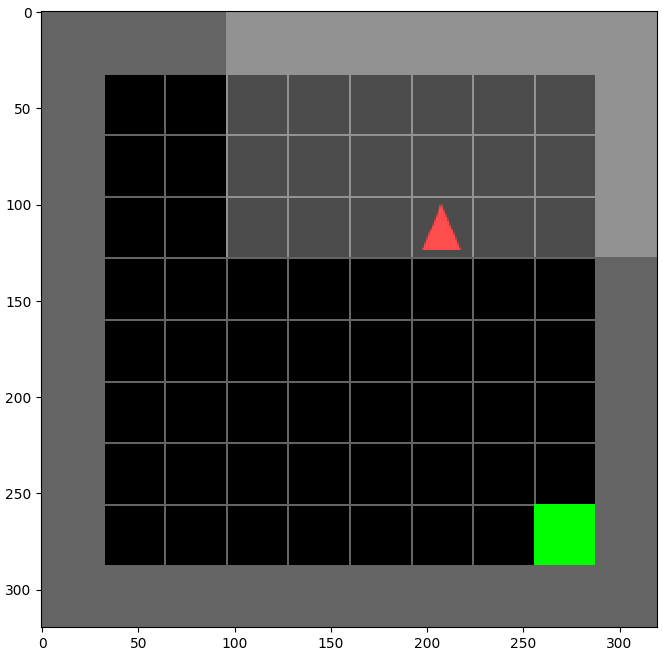

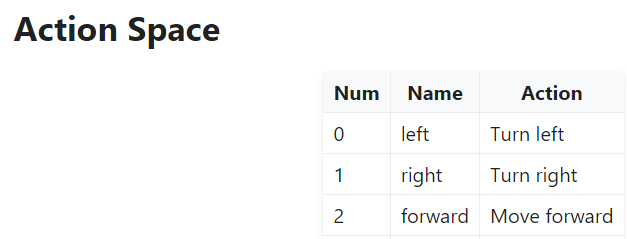

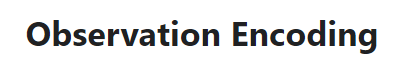

Agent Direction,
Agent Position,
Goal Position

Observation: (array([ 1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0, 10,  4,  1,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  8,  1,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0], dtype=uint8), {})

Agent position  (3, 1)
Agent direction  1
If Agent is carrying:  False
Goal position:  (8, 1)
number of actions po

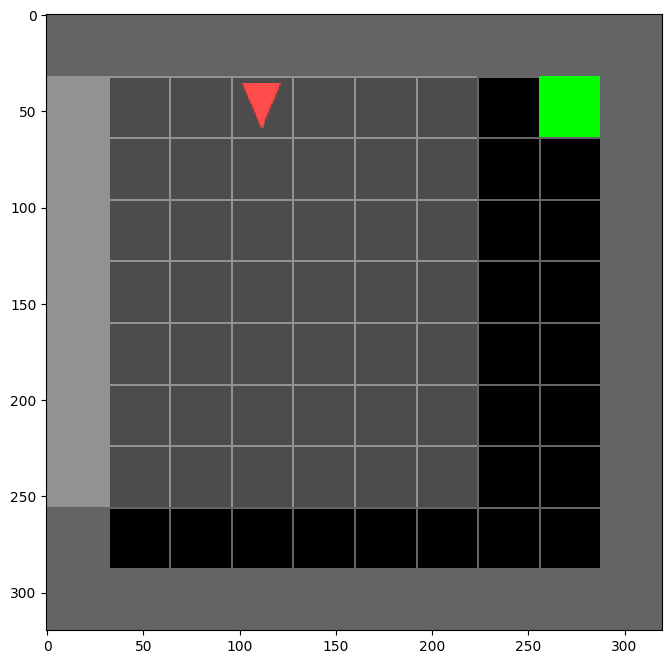

In [9]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=100))
obs = env.reset()
print("Observation:", obs)
print()
print("Agent position ", env.get_position())
print("Agent direction ", env.get_direction())
print("If Agent is carrying: ", env.is_carrying_key())
print("Goal position: ", env.get_goal_pos())
print("number of actions possible: ", env.action_space.n)
print()
screen = env.render()
plt.imshow(screen)

In [10]:
import inspect
# inspect.getmembers(env)
env.unwrapped.width

10

In [11]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


In [12]:
# obs = env.reset()
# # ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
# print('Carrying Key:', env.is_carrying_key())
# print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 1
Agent Position: (3, 1)
Goal position:  (8, 1)


In [13]:
#Random action plus visualization
max_steps = 100
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=max_steps))
obs = env.reset()
video_filename = '/content/fn.mp4'

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, raw_reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated #
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 99


# RandomKeyMEnv_10

### Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

- Wall is always in the third column.

- Key is always in the left part (left to the door).

- Goal is randomly in the right upper or lower corner.

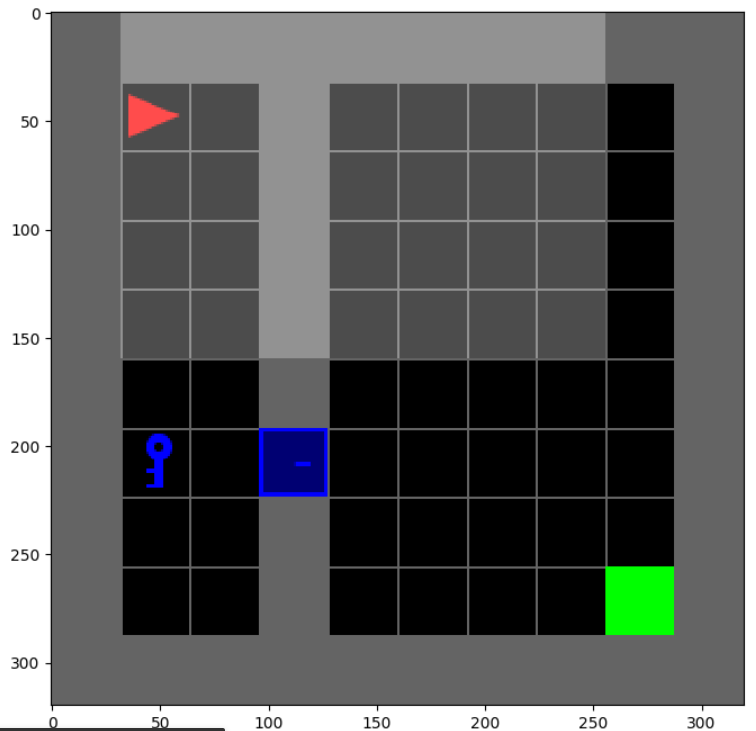

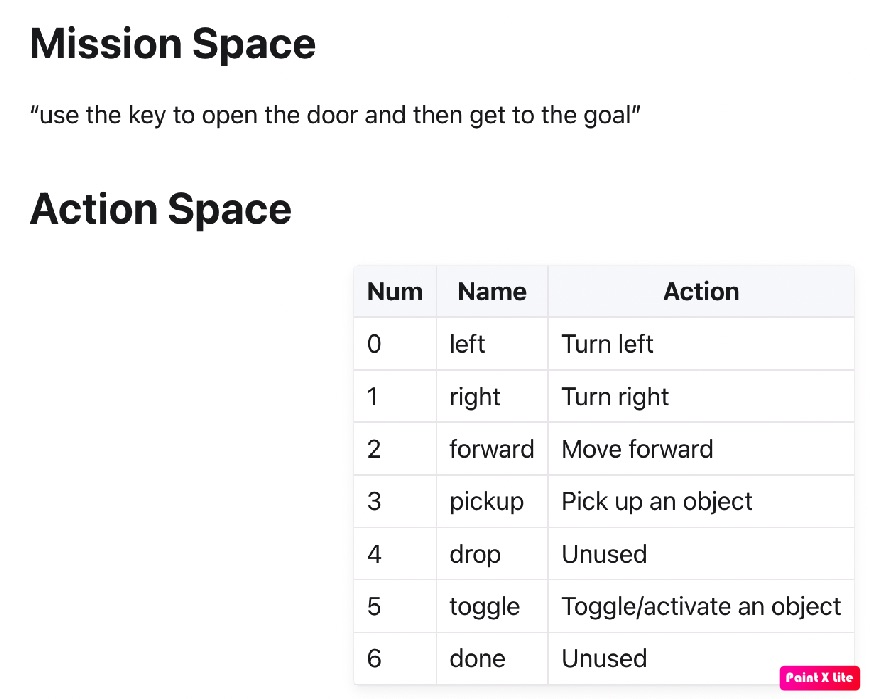

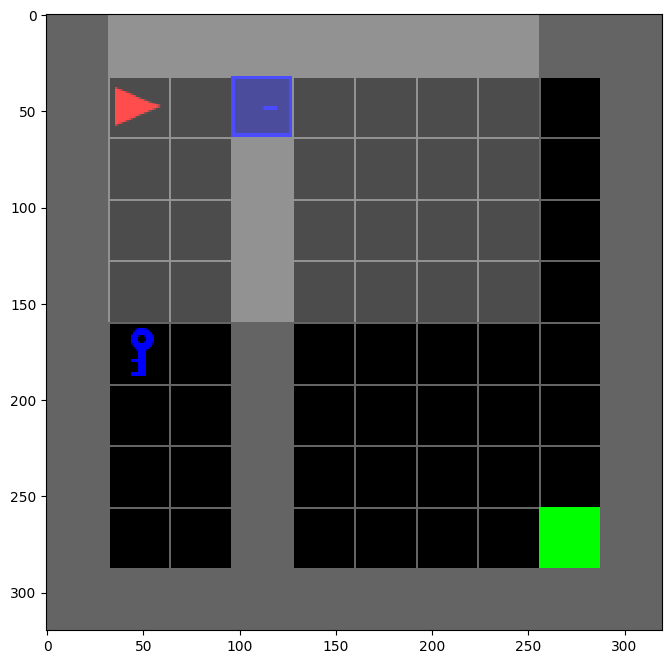

In [14]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array', max_steps=100))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [15]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


In [16]:
# env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
print('Carrying Key:', env.is_carrying_key())
print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (1, 1)
Goal position:  (8, 8)
Carrying Key: False
Door Open: False


# Your Code Below

# Imports

In [17]:
from abc import ABC, abstractmethod
from collections import defaultdict
from minigrid.minigrid_env import MiniGridEnv
from typing import Any, List, Tuple, Optional, Callable, Dict

# State Handler

### Explaining the main idea behind the class

#### Otimization points
$\text{Things we need to consider are the state space representation, it could be that our state space is too large, and need to determine our observation space}$

In [18]:
# ==========================================
# State Representation Component
# ==========================================
class StateHandler:
    """
    Handles conversion of MiniGrid observations to discrete (integer) states
    Mapping: (AgentX, AgentY, Direction, HoldingStatus) -> unique int
    """
    NUM_DIRECTIONS = 4  # possible agent directions 0-3


    def __init__(self, env: KeyFlatObsWrapper, use_key_door: bool = False):
        self.env = env
        self.use_key_door = use_key_door

        self.width = env.unwrapped.width
        self.height = env.unwrapped.height

        # use relative positions WRT targets (key/door/goal)
        # relative vector = (target-agent) , in the range [-width, +width] i.e.
        self.range_dimension = self.width * 2

        self.spatial_dimensions = (self.range_dimension * self.range_dimension) * self.NUM_DIRECTIONS

        # Env 2 has 3 game phases: 
        #   a) no key -> target is key
        #   b) have key, door closed -> target is door
        #   c) door open -> target is goal
        self.num_phases = 3 if self.use_key_door else 1
        self.num_states = self.spatial_dimensions * self.num_phases

        # # Inner dimensions (ignoring walls)
        # inner_w, inner_h = self.width - 2, self.height - 2
        # base_size = (inner_w * inner_h) * 4 * 3 # Pos * Dir * 3 Goals

        # if self.track_carrying:
        #   # We need 4 "pages" for the 4 combinations of Key and Door
        #   self.num_states = base_size * 4
        # else:
        #   self.num_states = base_size

    def get_state_index(self) -> int:
        """
        Calculates state index based on:
        1. current phase
        2. relative vector to target (key/door/goal)
        3. agent direction
        """

        # get agent position + direction
        agent_position = self.env.get_position()
        agent_direction = self.env.get_direction()

        # determine phase + target position:
        phase_offset = 0
        target_position = self.env.get_goal_pos()  # default (env 1) target is goal
        
        if self.use_key_door:
            has_key = self.env.is_carrying_key()
            is_door_open = self.env.is_door_open()

            # phase 0: no key -> target = key
            if not has_key:
                phase_offset = 0  
                target_position = self.env.get_key_pos()

            # phase 1: have key, door closed -> target = door
            elif has_key and not is_door_open:
                phase_offset = self.spatial_dimensions  
                target_position = self.env.get_door_pos()
            
            # phase 2: door open -> target = goal
            else:
                phase_offset = 2 * self.spatial_dimensions  
                target_position = self.env.get_goal_pos()
        
        # calculate relative vector (target - agent)
        dx = target_position[0] - agent_position[0]
        dy = target_position[1] - agent_position[1]

        # adjust to positive values for indexing
        dx += self.width
        dy += self.height

        # flatten to single int index
        idx = (dx * self.range_dimension + dy) * self.NUM_DIRECTIONS
        idx += agent_direction
        idx += phase_offset
        return idx
            
        # x, y = self.env.agent_pos
        # direction = self.env.agent_dir

        # # Optimization: Shift coordinates to ignore outer walls (0 and width-1)
        # # Reachable inner grid is (width-2) x (height-2)
        # adj_x, adj_y = x - 1, y - 1
        # inner_w, inner_h = self.width - 2, self.height - 2

        # # Base Physical Index (256 states for 10x10 env)
        # base_idx = (adj_y * inner_w + adj_x) * 4 + direction

        # goal_pos = env.get_goal_pos()
        # goal_map = {(8, 1): 0, (1, 8): 1, (8, 8): 2}
        # goal_id = goal_map.get(goal_pos, 0)

        # total_physical_states = inner_w * inner_h * 4
        # page_size = total_physical_states * 3

        # state_idx = base_idx + (goal_id * total_physical_states)
        # mode_idx = 0

        # if self.track_carrying:
        #   # Check Carrying
        #   carrying_val = 1 if env.carrying is not None else 0

        #   # Check Door (Manual loop because is_door_open doesn't exist)
        #   door_val = 0
        #   for obj in env.unwrapped.grid.grid:
        #       if obj and obj.type == 'door' and obj.is_open:
        #           door_val = 1
        #           break

        #   # This creates 4 distinct pages:
        #   # Mode 0 (Index 0-767): No Key, Door Closed
        #   # Mode 1 (Index 768-1535): Carrying Key, Door Closed
        #   # Mode 2 (Index 1536-2303): No Key, Door Open
        #   # Mode 3 (Index 2304-3071): Carrying Key, Door Open
        #   mode_idx = (door_val * 2) + carrying_val

        # state_idx += (mode_idx * page_size)


        # return int(state_idx)

    # # todo
    # def get_readable_state(self, state_idx: int) -> Tuple[int, int, int, int]:
    #     """
    #     Reverse mapping for debugging: index -> (x, y, dir, is_carrying)
    #     """
    #     # handle carrying status
    #     carrying_offset = (self.width * self.height * 4)
    #     is_carrying = 0
    #     if self.track_carrying and state_idx >= carrying_offset:
    #         is_carrying = 1
    #         state_idx -= carrying_offset

    #     # extract direction + position
    #     direction = state_idx % 4
    #     position_idx = state_idx // 4

    #     # extract x, y (the <x * height + y> part)
    #     y = position_idx % self.height
    #     x = position_idx // self.height

    #     return (x, y, direction, is_carrying)

## Utils

In [19]:
import imageio

def record_agent_video(env, agent, state_handler, filename, max_steps=200):
    """
    Records a video of the agent's current policy (greedy).
    """
    # Ensure the environment is in the right mode
    # Note: env must be initialized with render_mode='rgb_array'

    with imageio.get_writer(filename, fps=10) as video:
        obs, _ = env.reset()
        mg_env = env.unwrapped

        # Reset milestones for the video run
        global milestones
        milestones = {"key_rewarded": False, "door_rewarded": False}

        state = state_handler.get_state_index(mg_env)
        done = False
        truncated = False
        step_count = 0

        while not (done or truncated) and step_count < max_steps:
            # Use greedy action (epsilon=0) to see what the agent has "learned"
            action = agent.choose_action(state, force_greedy=True)

            obs, reward, done, truncated, info = env.step(action)
            state = state_handler.get_state_index(mg_env)

            # Capture the frame
            video.append_data(env.render())
            step_count += 1

        print(f"Video saved to {filename} (Steps: {step_count})")

# Base Agent Class

### All Algorithms will inherit this components

In [ ]:
# ==========================================
# Base class for Agent Components
# ==========================================
class BaseAgent(ABC):
    """
    Base class for all Tabular RL agents
    Handles Q-table init, action selection, hyperparameters
    """
    def __init__(self, num_states: int, num_actions: int, lr: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.lr = lr            # learning rate (alpha)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # exploration rate

        self.allowed_actions = list(range(self.num_actions))    # for specific env, if provided

        # init Q-table
        # random init # todo: consider other inits optoins
        #self.q_table = np.random.uniform(low=0, high=0.01, size=(num_states, num_actions))
        # Initialise all values to 1 enable better exploration
        #self.q_table = np.ones((num_states, num_actions))
        self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state_idx: int, force_greedy: bool = False, allowed_actions: Optional[List[int]] = None) -> int:
        """
        Epsilon-greedy action selection
        :param state_idx: current state index
        :param force_greedy: controls exploration (ignores epsilon) for inference/testing
        :return : selected action index
        """

        # remove disabled actions if provided
        if allowed_actions is None:
            actions = np.array(list(range(self.num_actions)), dtype=int)
        else:
            actions = np.array(allowed_actions, dtype=int)        

        if not force_greedy and np.random.uniform(0, 1) < self.epsilon:
            # explore:
            selected_action = np.random.choice(actions)
        else:
            # exploit:
            qt = self.q_table[state_idx, actions]                       # get Q-table row for current state
            best_actions = np.flatnonzero(qt == qt.max())               # get all actions with max Q-value (1 or more)
            selected_action = np.random.choice(actions[best_actions])   # break ties randomly (if multiple best)
            
            # DEBUG: # todo
            if allowed_actions is not None:
                assert selected_action in actions

        return int(selected_action)

    @abstractmethod
    def update(self, *args) -> None:
        # todo: implement by inheriting classes
        raise NotImplementedError("This method should be overridden by subclasses")

    def save_q_table(self, filename: str = "q_table.pkl") -> None:
        """Util for saving Q-table to file"""
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename: str = "q_table.pkl") -> None:
        """Util for loading Q-table from file"""
        with open(filename, "rb") as f:
            self.q_table = pickle.load(f)

# Q-Learning



In [21]:
class QLearningAgent(BaseAgent):
    def update(self, state: int, action: int, reward: float, next_state: int, done: bool) -> None:
        """
        Q-Learning update (off-policy):
        Q(s,a) <- Q(s,a) + alpha * [reward + gamma * max(Q(s',a')) - Q(s,a)]
        """

        if done:
            max_next_q = 0.0
        else:
            if not self.allowed_actions:
                max_next_q = np.max(self.q_table[next_state])
            else:
                max_next_q = np.max(self.q_table[next_state, self.allowed_actions])

        td_target = reward + self.gamma * max_next_q

        current_q = self.q_table[state][action]
        self.q_table[state][action] += self.lr * (td_target - current_q)
    
    @property
    def name(self) -> str:
        return "Q-Learning Agent"

# SARSA

In [22]:
class SARSAAgent(BaseAgent):
    def update(self, state: int, action: int, reward: float, next_state: int, next_action: int, done: bool) -> None:
        """
        SARSA update (On-Policy):
        Q(s,a) <- Q(s,a) + alpha * [reward + gamma * Q(s',a') - Q(s,a)]
        """
        next_q = self.q_table[next_state][next_action] if not done else 0.0
        td_target = reward + self.gamma * next_q

        current_q = self.q_table[state][action]
        self.q_table[state][action] += self.lr * (td_target - current_q)
    
    @property
    def name(self) -> str:
        return "SARSA Agent"


# Monte-Carlo

#### On Policy first-visit MC control (for $\epsilon$-soft policies), estimates $\pi \approx \pi_*$



In [23]:
class MCAgent(BaseAgent):
    def __init__(self, num_states: int, num_actions: int, lr: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        super().__init__(num_states, num_actions, lr, gamma, epsilon)
        # MC needs to store returns for averaging
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.episode_buffer: List[Tuple[int, int, float]] = []

    def store_transition(self, state: int, action: int, reward: float) -> None:
        """Store each step for processing at end of episode"""
        step = (state, action, reward)
        self.episode_buffer.append(step)

    def update(self) -> None:
        """
        MC update:
        - executed at END of an episode
        - iterates backwards through episode buffer
        """
        G: float = 0.0 # cumulative return
        visited_pairs = set()

        # traverse episode backwards
        for state, action, reward in reversed(self.episode_buffer):
            G = self.gamma * G + reward

            # first-visit MC check
            if (state, action) not in visited_pairs:
                visited_pairs.add((state, action))

                # rolling mean update: Q(s,a) = Q(s,a) + alpha * (G - Q(s,a))
                # todo: consider 1/n returns avg instead of const alpha
                old_q = self.q_table[state][action]
                self.q_table[state][action] += self.lr * (G - old_q)

        self.episode_buffer = [] # clear buffer
    
    @property
    def name(self) -> str:
        return "MC Agent"

# Experimenting

In [24]:
milestones = {
    "key_rewarded": False,
    "door_rewarded": False
}

def key_door_reward_shaping(reward, env, done, info):
    """
    Shaped reward function for the DoorKey environment.
    Uses helper methods: is_carrying_key() and is_door_open().
    """
    global milestones
    inner_env = env.unwrapped
    shaped_reward = 0 # -ive paralyses the agents

    agent_pos = inner_env.agent_pos
    goal_pos = inner_env.get_goal_pos()
    key_pos = inner_env.get_key_pos() if hasattr(inner_env, 'get_key_pos') else None
    door_pos = inner_env.get_door_pos() if hasattr(inner_env, 'get_door_pos') else None

    is_carrying_key = inner_env.carrying is not None and inner_env.carrying.type == 'key'

    is_door_open = False
    for obj in inner_env.grid.grid:
      if obj and obj.type == 'door' and obj.is_open:
        is_door_open = True
        break

    if not milestones["key_rewarded"] and key_pos:
        dist = abs(agent_pos[0] - key_pos[0]) + abs(agent_pos[1] - key_pos[1])
        shaped_reward += (1.0 / (dist + 1)) * 0.2  # Small pull toward key

        if is_carrying_key:
            shaped_reward += 10.0
            milestones["key_rewarded"] = True
            #print("Milestone 1: Key Secured")

    elif not milestones["door_rewarded"] and is_carrying_key and door_pos:
        dist = abs(agent_pos[0] - door_pos[0]) + abs(agent_pos[1] - door_pos[1])
        shaped_reward += (1.0 / (dist + 1)) * 0.2

        if is_door_open:
            shaped_reward += 10.0
            milestones["door_rewarded"] = True
            #print("Milestone 2: Door Unlocked")

    elif is_door_open:
      dist = abs(agent_pos[0] - goal_pos[0]) + abs(agent_pos[1] - goal_pos[1])
      shaped_reward += (1.0 / (dist + 1)) * 0.2

    if reward > 0 or np.array_equal(agent_pos, goal_pos):
            shaped_reward += 20.0
            #print("goal Reached")

    return shaped_reward

In [25]:
class ExperimentRunner:
    """
    Manages training loop, logging, env interaction
    """
    # todo: type hints
    def __init__(self, env_class: Any, agent_class: Any, num_episodes: int = 1000, max_steps: int = 100,
                 reward_shaping_func: Optional[Callable] = None, **agent_kwargs):
        
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.reward_shaping_func = reward_shaping_func

        # create new env from scratch
        self.raw_env = env_class(render_mode="rgb_array", max_steps=max_steps)
        self.env = KeyFlatObsWrapper(self.raw_env)

        # definitions specific to key-door env
        is_key_door_env = False
        self.allowed_actions = None
        if env_class == RandomKeyMEnv_10:
            is_key_door_env = True
            self.allowed_actions = [0, 1, 2, 3, 5]  # disable actions: 'drop' (4), 'done' (6)

        # state handler
        self.state_handler = StateHandler(env=self.env, use_key_door=is_key_door_env)

        # create new agent from scrtch
        self.agent = agent_class(
            num_actions=self.env.action_space.n,
            num_states=self.state_handler.num_states,
            **agent_kwargs
        )
        self.agent.allowed_actions = self.allowed_actions

    def run(self) -> Tuple[List[float], List[float], List[int], List[int]]:
        """
        Main training loop over game episodes
        :return : rewards history, steps history
        """
        raw_rewards_history = []
        shaped_rewards_history = []
        steps_history = []
        success_history = []

        # DEBUG: action counts # todo
        action_counts_window = []
        got_key_hist = []
        opened_door_hist = []


        for episode in range(self.num_episodes):
        
            # DEBUG: print action space size # todo
            if episode == 0:
                print("env.action_space.n =", self.env.action_space.n)

            self.env.reset()
            state = self.state_handler.get_state_index()
            
            # episode termination indicators
            done = False
            truncated = False       

            # reward trackers
            total_raw_reward = 0
            total_shaped_reward = 0

            steps = 0               # step counter
            success = 0             # success metric

            # DEBUG: action counts # todo
            action_counts = np.zeros(self.env.action_space.n, dtype=int)

            # track state changes for reward shaping
            got_key = False
            opened_door = False

            # for SARSA - needs actoin before loop
            action = 0
            if isinstance(self.agent, SARSAAgent):
                action = self.agent.choose_action(state_idx=state, allowed_actions=self.allowed_actions)
            
            while not done and not truncated:
                if not isinstance(self.agent, SARSAAgent):
                    action = self.agent.choose_action(state_idx=state, allowed_actions=self.allowed_actions)
                
                # DEBUG: count actions # todo
                action_counts[action] += 1

                # step:
                obs, raw_reward, done, truncated, _ = self.env.step(action)
                terminal = done or truncated    # treat truncated as terminal # todo: confirm this
                next_state = self.state_handler.get_state_index()
                
                # todo
                # reward shaping hook:
                training_reward = raw_reward
                if self.reward_shaping_func:
                    training_reward = self.reward_shaping_func(
                        self.env,
                        raw_reward, 
                        got_key,
                        opened_door, 
                    )
                got_key = got_key or self.env.is_carrying_key()
                opened_door = opened_door or self.env.is_door_open()

                # update:
                # **use training reward
                if isinstance(self.agent, QLearningAgent):
                    self.agent.update(
                        state=state,
                        action=action,
                        reward=training_reward,
                        next_state=next_state,
                        done=terminal
                    )
                elif isinstance(self.agent, SARSAAgent):
                    next_action = 0 if terminal else self.agent.choose_action(state_idx=next_state, allowed_actions=self.allowed_actions)
                    self.agent.update(
                        state=state,
                        action=action,
                        reward=training_reward,
                        next_state=next_state,
                        next_action=next_action,
                        done=terminal
                    )
                    action = next_action
                elif isinstance(self.agent, MCAgent):
                    self.agent.store_transition(
                        state=state,
                        action=action,
                        reward=training_reward
                    )
                
                state = next_state

                # log both rewards
                total_raw_reward += raw_reward
                total_shaped_reward += training_reward

                # signal success if reached goal
                if done and raw_reward > 0:
                    success = 1  

                steps += 1
            
            # end of episode update for MC
            if isinstance(self.agent, MCAgent):
                self.agent.update()
            
            # decay epsilon
            if hasattr(self.agent, 'epsilon') and self.agent.epsilon > 0.01:
                self.agent.epsilon *= 0.995

            raw_rewards_history.append(total_raw_reward)
            shaped_rewards_history.append(total_shaped_reward)
            steps_history.append(steps)
            success_history.append(success)

            # DEBUG: action counts # todo
            action_counts_window.append(action_counts)
            if len(action_counts_window) > 100:
                action_counts_window.pop(0)
            got_key_hist.append(int(got_key))
            opened_door_hist.append(int(opened_door))


            if (episode + 1) % 100 == 0:
                avg_reward_raw = np.mean(raw_rewards_history[-100:])
                avg_reward_shaped = np.mean(shaped_rewards_history[-100:])
                success_rate = float(np.mean(success_history[-100:])) * 100.0
                print(f"[{self.agent.name}] Episode {episode + 1}/{self.num_episodes} | "
                      f"Avg RAW Reward (last 100 ep.): {avg_reward_raw:.2f} | "
                      f"Avg SHAPED Reward (last 100 ep.): {avg_reward_shaped:.2f} | "
                      f"success={success_rate:.1f}%")
                
                # DEBUG: print action counts # todo
                avg_counts = np.mean(np.stack(action_counts_window, axis=0), axis=0)
                # MiniGrid action names by index: 0 left, 1 right, 2 forward, 3 pickup, 4 drop, 5 toggle, 6 done
                # (your key env uses 6 actions: 0..5, so 'done' isn't present)
                names = ["left", "right", "forward", "pickup", "drop", "toggle", "done"]
                for i, name in enumerate(names[:self.env.action_space.n]):
                    print(f"  avg {name}: {avg_counts[i]:.1f}")
                print(f"  mean steps (last 100): {np.mean(steps_history[-100:]):.1f}")
                print(f"  sum(avg action counts): {avg_counts.sum():.1f}")
                print(f"  got_key% (last 100): {100*np.mean(got_key_hist[-100:]):.1f}%")
                print(f"  door_open% (last 100): {100*np.mean(opened_door_hist[-100:]):.1f}%")


        return raw_rewards_history, shaped_rewards_history, steps_history, success_history

    def close(self) -> None:
        self.env.close()

In [ ]:
def evaluate(env, agent, state_handler, episodes=100):
    rewards = []
    steps = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # greedy

    for _ in range(episodes):
        obs, _ = env.reset()
        mg_env = env.unwrapped
        state = state_handler.get_state_index(mg_env)

        total_reward = 0
        for step in range(200):
            action = agent.choose_action(state, force_greedy=True)
            _, reward, done, truncated, _ = env.step(action)
            state = state_handler.get_state_index(mg_env)
            total_reward += reward
            if done or truncated:
                break

        rewards.append(total_reward)
        steps.append(step + 1)

    agent.epsilon = old_epsilon
    return rewards, steps

# Sanity Tests

In [ ]:
# Create the environment
env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=100))

# Initialize StateHandler
sh_empty = StateHandler(env_empty.unwrapped, track_carrying=False)
sh_key = StateHandler(env_key.unwrapped, track_carrying=True)

# Reset environments
obs_empty = env_empty.reset()
obs_key = env_key.reset()

# Get discrete state indices
state_idx_empty = sh_empty.get_state_index(env_empty.unwrapped)
state_idx_key = sh_key.get_state_index(env_key.unwrapped)

# Print results
print("RandomEmptyEnv_10:")
print("Agent pos:", env_empty.get_position())
print("Direction:", env_empty.get_direction())
print("State index:", state_idx_empty)
print("Total states:", sh_empty.num_states)
print("The range of states are: ", sh_empty.num_states-1)


print("\nRandomKeyEnv_10:")
print("Agent pos:", env_key.get_position())
print("Direction:", env_key.get_direction())
print("Carrying key:", env_key.is_carrying_key())
print("State index:", state_idx_key)
print("Total states:", sh_key.num_states)

## Testing state transitions

In [ ]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
state_handler = StateHandler(env.unwrapped, track_carrying=False)

env.reset()
s0 = state_handler.get_state_index(env.unwrapped)

env.step(2)   # move forward
s1 = state_handler.get_state_index(env.unwrapped)

print("s0:", s0)
print("s1:", s1)
print("Changed:", s0 != s1)

## Testing action effects explicitely

In [ ]:
env.reset()

print("Before:", env.get_position(), env.get_direction())
env.step(0)   # turn left
print("After left:", env.get_position(), env.get_direction())

env.step(2)   # forward
print("After forward:", env.get_position(), env.get_direction())

### Testing state check

In [ ]:
env.reset()

for _ in range(10):
    _, r, _, _, _ = env.step(2)
    print("Reward:", r)

# Empty Environment - Training and Evaluation


 STARTING TEST ON ENV 2: RandomKeyMEnv_10

Training Monte Carlo in environment <class '__main__.RandomKeyMEnv_10'>...
env.action_space.n = 7
[MC Agent] Episode 100/1000 | Avg RAW Reward (last 100 ep.): 0.02 | Avg SHAPED Reward (last 100 ep.): 24.31 | success=2.0%
  avg left: 49.2
  avg right: 48.0
  avg forward: 49.1
  avg pickup: 51.9
  avg drop: 0.0
  avg toggle: 49.7
  avg done: 0.0
  mean steps (last 100): 247.9
  sum(avg action counts): 247.9
  got_key% (last 100): 97.0%
  door_open% (last 100): 66.0%
[MC Agent] Episode 200/1000 | Avg RAW Reward (last 100 ep.): 0.03 | Avg SHAPED Reward (last 100 ep.): 34.95 | success=3.0%
  avg left: 37.7
  avg right: 38.1
  avg forward: 46.7
  avg pickup: 57.6
  avg drop: 0.0
  avg toggle: 67.3
  avg done: 0.0
  mean steps (last 100): 247.5
  sum(avg action counts): 247.5
  got_key% (last 100): 100.0%
  door_open% (last 100): 98.0%
[MC Agent] Episode 300/1000 | Avg RAW Reward (last 100 ep.): 0.18 | Avg SHAPED Reward (last 100 ep.): 38.95 | succe

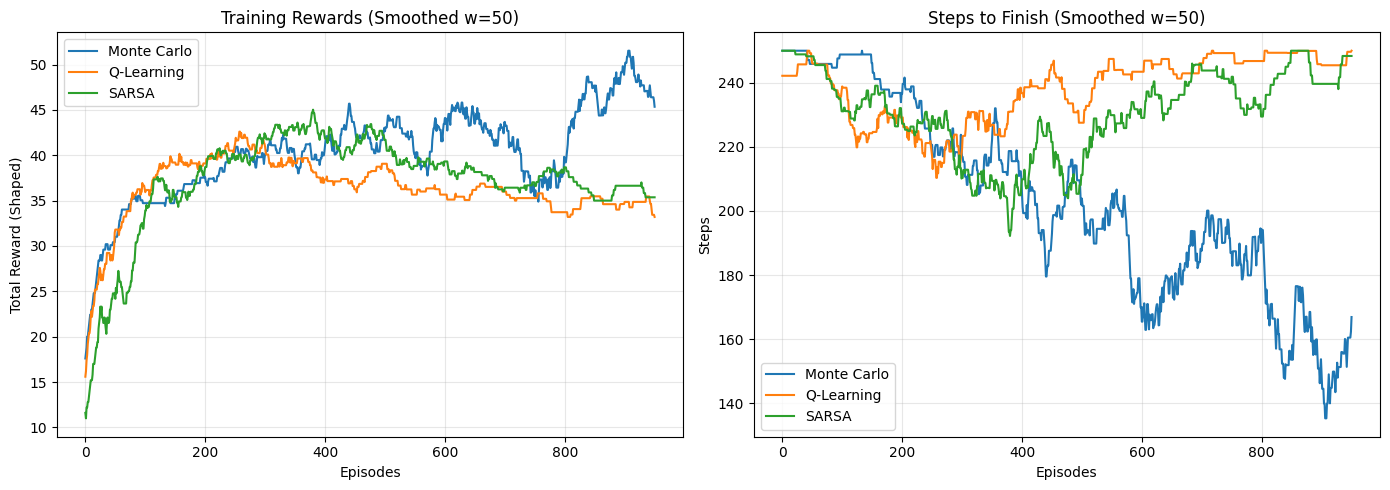

In [29]:
# define reward shaping function to pass to exp runner
def key_door_reward_shaping(env: KeyFlatObsWrapper, reward: float , key_bonus_given: bool, door_bonus_given: bool) -> float:
    """
    Reward shaping to guide agent in env 2
    """
    
    # penalty - step cost
    if reward == 0:
        reward -= 0.1

    # todo
    if reward == 1:
        reward = 10.0

    # bonus - picked up key
    if env.is_carrying_key() and not key_bonus_given:
        reward += 30.0 
    
    # bonus - opened door
    if env.is_door_open() and not door_bonus_given:
        reward += 30.0
        
    return reward

def plot_success(results_dict: Dict, window: int = 50) -> None:
    plt.figure(figsize=(10, 4))
    
    for name, data in results_dict.items():
        success = np.array(data["train_success"], dtype=float)
        if len(success) > window:
            smoothed = np.convolve(success, np.ones(window)/window, mode="valid")
            plt.plot(smoothed, label=name)
        else:
            plt.plot(success, label=name)

    plt.title(f"Success Rate (Smoothed w={window})")
    plt.xlabel("Episodes")
    plt.ylabel("Success (0..1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_rewards(results_dict: Dict, window: int = 50) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # plot 1: rewards
    for name, data in results_dict.items():
        rewards = data["train_rewards_shaped"]

        # todo: remove?
        # smoothing
        if len(rewards) > window:
            smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
            axes[0].plot(smoothed, label=name)
        else:
            axes[0].plot(rewards, label=name)
            
    axes[0].set_title(f"Training Rewards (Smoothed w={window})")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Total Reward (Shaped)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # plot 2: steps
    for name, data in results_dict.items():
        steps = data["train_steps"]
        if len(steps) > window:
            smoothed = np.convolve(steps, np.ones(window)/window, mode='valid')
            axes[1].plot(smoothed, label=name)
        else:
            axes[1].plot(steps, label=name)
            
    axes[1].set_title(f"Steps to Finish (Smoothed w={window})")
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Steps")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# agents to test
agents = {
    "Monte Carlo": MCAgent,
    "Q-Learning": QLearningAgent,
    "SARSA": SARSAAgent
}

# hyperparameters
params = {
    "lr": 0.02,
    "gamma": 0.99,
    "epsilon": 1.0 # exp runner handles decay internally if implemented in agent
}

# test env 2:
print("\n" + "="*50)
print(" STARTING TEST ON ENV 2: RandomKeyMEnv_10")
print("="*50)

results = {}
env_cls = RandomKeyMEnv_10

for agent_name, agent_cls in agents.items():
    print(f"\nTraining {agent_name} in environment {env_cls}...")
    
    runner = ExperimentRunner(
        env_class=env_cls,# todo: parameterize env class
        agent_class=agent_cls,
        num_episodes=1000,          
        max_steps=250,
        reward_shaping_func=key_door_reward_shaping,
        **params  # lr, gamma, epsilon
    )

    train_rewards_raw, train_rewards_shaped, train_steps, train_success = runner.run()

    results[agent_name] = {
        "train_rewards_raw": train_rewards_raw,
        "train_rewards_shaped": train_rewards_shaped,
        "train_steps": train_steps,
        "train_success": train_success,
    }
    
    # cleanup
    runner.close()

print("\nAll experiments complete.")

# generate Plots
plot_rewards(results)

In [ ]:
total_episodes = 1000
eval_interval = 100
eval_episodes = 10

# Set up

# Envrionment 1
state_handler = StateHandler(env.unwrapped, track_carrying=False)
env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))


# Envrionment 2
env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=250))
sh_key = StateHandler(env_key.unwrapped, track_carrying=True)

# Debugger Attribute
#print("Available methods/attributes:", dir(env_key.unwrapped))

num_states_key = sh_key.num_states
num_actions_key = env_key.action_space.n

num_states = state_handler.num_states
num_actions = env.action_space.n

agents = {
    # An Optimal Solution for MC
    "Monte Carlo": MCAgent(num_states=num_states_key, num_actions = num_actions_key, lr=0.01, gamma =0.99, epsilon = 1.0),
    # An Optimal Solution for Q-Learning
    "Q-Learning": QLearningAgent(num_states=num_states_key, num_actions=num_actions_key, lr=0.02, gamma=0.99, epsilon=1.0),
    # An Optimal Solution for SARSA
    "SARSA": SARSAAgent(num_states=num_states_key, num_actions=num_actions_key, lr=0.02, gamma = 0.99, epsilon=1.0)
}

inference_checkpoints = list(range(eval_interval, total_episodes + 1, eval_interval))

# Dictionary to store results for the report
results = {}

for agent_name, agent in agents.items():
    print(f"\n--- Starting Training for {agent_name} ---")

    """
    runner = ExperimentRunner(
        env=env,
        agent=agent,
        state_handler=sh,
        max_steps=100,
        reward_shaping_func=None
    )
    """
    runner_key = ExperimentRunner(
        env=env_key,
        agent=agent,
        state_handler=sh_key,
        max_steps=250,
        reward_shaping_func=key_door_reward_shaping
    )
    midpoint = total_episodes // 2

    all_train_rewards = []
    inference_avg_steps = []
    inference_avg_rewards = []

    for start_ep in range(0, total_episodes, eval_interval):
        # Training Phase
        train_rewards, _ = runner_key.run_training(eval_interval, print_info=True)
        current_ep = start_ep + eval_interval
        if current_ep == midpoint:
            print(f"!!! Capturing Mid-Training Video for {agent_name} !!!")
            video_path = f"training_midpoint_{agent_name.replace(' ', '_')}.mp4"
            record_agent_video(env_key, agent, sh_key, video_path)
        all_train_rewards.extend(train_rewards)

        # Inference Phase (Greedy evaluation)
        # eval_rewards, eval_steps = evaluate(env, agent, sh, episodes=eval_episodes)
        eval_rewards, eval_steps = evaluate(env_key, agent, sh_key, episodes=eval_episodes)

        # Calculate and store the average for plotting
        avg_step = np.mean(eval_steps)
        avg_reward = np.mean(eval_rewards)
        inference_avg_steps.append(avg_step)
        inference_avg_rewards.append(avg_reward)

        print(f"Episode {start_ep + eval_interval} | Inference Avg Steps: {avg_step:.2f}")

    results[agent_name] = {
        "train_rewards": all_train_rewards,
        "inference_steps": inference_avg_steps,
        "inference_rewards": inference_avg_rewards,
        "key_success": runner_key.key_history,
        "door_success": runner_key.door_history,
        "goal_success": runner_key.goal_history
    }

    # Clean up the runner for the next agent
    runner_key.close()

# Graphs for comparison

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rl_results(results, inference_checkpoints, window_size=100):
    # We expand to 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    ax1, ax2 = axes[0, 0], axes[0, 1]  # Row 1
    ax3 = axes[1, 0]                   # Row 2, Col 1 (Success Plot)
    # axes[1, 1] can be empty or used for a different metric

    # --- Plot 1: Training Convergence (Rewards) ---
    for name, data in results.items():
        rewards = np.array(data["train_rewards"])
        if len(rewards) > 1000: rewards = rewards[:1000]

        if len(rewards) >= window_size:
            smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            x_axis = np.arange(window_size, len(rewards)+1)
            ax1.plot(x_axis, smoothed, label=f"{name}")
        else:
            ax1.plot(rewards, label=f"{name} (raw)", alpha=0.3)

    ax1.set_title("Training Convergence: Smoothed Rewards")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel(f"Reward ({window_size}-Episode Avg)")
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: Inference Efficiency (Steps) ---
    for name, data in results.items():
        ax2.plot(inference_checkpoints, data["inference_steps"], marker='o', linewidth=2, label=name)

    ax2.set_title("Inference Stage: Avg Steps to Goal")
    ax2.set_xlabel("Training Episodes Completed")
    ax2.set_ylabel("Steps (Lower is Better)")
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- Plot 3: Milestone Success Rates ---
    # We will plot the "Goal Success" for all agents here to compare them
    for name, data in results.items():
        goal_data = np.array(data["goal_success"])
        if len(goal_data) > 1000: goal_data = goal_data[:1000]

        if len(goal_data) >= window_size:
            smoothed_goal = np.convolve(goal_data, np.ones(window_size)/window_size, mode='valid')
            x_axis = np.arange(window_size, len(goal_data)+1)
            ax3.plot(x_axis, smoothed_goal, label=f"{name}")

    ax3.set_title("Mission Success Rate (Reaching Goal)")
    ax3.set_xlabel("Episodes")
    ax3.set_ylabel(f"Success % ({window_size}-Ep Avg)")
    ax3.set_ylim(-0.05, 1.05) # Keeps success between 0 and 100%
    ax3.legend()
    ax3.grid(True, linestyle=':', alpha=0.6)

    # --- Plot 4: (e.g., Key Discovery Rate for a specific agent) ---
    # Alternatively, you can use axes[1, 1] to show how "Key" leads to "Door"
    # copy and paste this into agent : Q-Learning , Monte Carlo, SARSA
    agent = "Monte Carlo"
    if agent in results:
        res = results[agent]
        for metric, label_name in [("key_success", "Found Key"), ("door_success", "Opened Door")]:
            metric_data = np.array(res[metric])
            if len(metric_data) > 1000: metric_data = metric_data[:1000]
            smoothed_m = np.convolve(metric_data, np.ones(window_size)/window_size, mode='valid')
            axes[1, 1].plot(np.arange(window_size, len(metric_data)+1), smoothed_m, label=label_name)

        axes[1, 1].set_title(f"Sequential Milestone Mastery ({agent})")
        axes[1, 1].set_xlabel("Episodes")
        axes[1, 1].set_ylabel("Discovery Rate")
        axes[1, 1].legend()
        axes[1, 1].grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.savefig("DetailedExperimentAnalysis.png")
    plt.show()

plot_rl_results(results, inference_checkpoints)

In [ ]:
# Envrionment 1
env1 = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
state_handler1 = StateHandler(env1.unwrapped, use_key_door=False)

# Envrionment 2
env2 = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=250))
state_handler2 = StateHandler(env2.unwrapped, use_key_door=True)

{'dtype': dtype('int64'),
 'n': np.int64(3),
 'start': np.int64(0),
 '_shape': (),
 '_np_random': None}